In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload

In [2]:
import sys
sys.path.append('../')

In [3]:
from src.utils import show_prompt
from src.prompt import logistician_prompt
show_prompt(logistician_prompt, "logistician_prompt")

c:\Users\kamalmo\Desktop\AI\InboundLogisticSystem\MultiAgentInboundLogistic\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


╭────────────────────────────────────────────── logistician_prompt ───────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [4]:
%%writefile ../src/state_logistician.py

"""State Definitions and Pydantic Schemas for Research Scoping.

This defines the state objects and structured schemas used for
the research agent scoping workflow, including researcher state management and output schemas.
"""

import operator
from typing_extensions import Optional, Annotated, List, Sequence
from datetime import date

from langchain_core.messages import BaseMessage
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from enum import Enum

# ===== STATE DEFINITIONS =====

class LogisticianState(MessagesState):
    """State for the logistician agent"""
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    agent_brief: str

# ===== STRUCTURED OUTPUT SCHEMAS =====

class LogisticianSchema(BaseModel):
    """Schema for logistician router decision making."""
    missing_mandatory_fields: List[str] = Field(
        description="List of missing mandatory fields"
    )
    missing_optional_fields: List[str] = Field(
        description="List of missing optional fields"
    )
    is_confirmed_by_user: bool = Field(
        description="indicates whether has been confirmed by the user or not",
        default=False
    )
    AWB: str = Field(
        description="AWB Description"
    )
    product_temperature: str = Field(
        description="Product Temperature Description",
    )
    handover_to_clearance: Optional[date] = Field(
        description="date of handover to clearance",
    )
    shipment_mode: str = Field(
        description="shipment mode",
    )

Overwriting ../src/state_logistician.py


In [8]:
%%writefile ../src/logistician_agent.py

"""This code contains the code for the logistician agent"""

from datetime import datetime
from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_community.chat_models import ChatDeepInfra
from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
import os
from src.prompt import missing_mandatory_fields_prompt, missing_optional_fields_prompt, \
                        logistician_confirmation_prompt, logistician_prompt, summarize_logistician_system_prompt, \
                        summarize_logistician_human_prompt
from src.state_logistician import LogisticianSchema, LogisticianState

# ===== UTILITY FUNCTIONS =====

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %#d, %Y")

# ===== CONFIGURATION =====

# Initialize model
model = init_chat_model(model="openai:gpt-4.1", temperature=0.0)
summarize_model = model

tools = []
tools_by_name = {tool.name: tool for tool in tools}

# Bind model with tools
model = model.bind_tools(tools)

def logistician_agent(state: LogisticianState) -> Command[Literal["__end__", "logistician_tools", "confirm_with_user", "commit_logistics_transaction"]]:
    """
    
    """
    # Set up structured output model
    structured_output_model = model.with_structured_output(LogisticianSchema)

    # Invoke the model with clarification instructions
    response = structured_output_model.invoke([
        HumanMessage(content=logistician_prompt.format(
            agent_brief=state["supervisor_messages"][-1].agent_brief, 
            date=get_today_str()
        ))
    ])

    if response.tool_calls: # if it needs a tool
        return Command(
            goto="logistician_tools", 
            update={"supervisor_messages": [response]}
        )
    elif response.missing_mandatory_fields: # if there is a missing mandatory fields
        return Command(
            goto=END, 
            update={"messages": [AIMessage(content=missing_mandatory_fields_prompt.format(
                missing_fields=response.missing_mandatory_fields))]}
        )
    elif response.missing_optional_fields and not response.is_confirmed_by_user: # missing optional fields before confirmation
        return Command(
            goto=END, 
            update={"messages": [AIMessage(content=missing_optional_fields_prompt.format(
                missing_fields=response.missing_optional_fields))]}
        )
    elif not response.is_confirmed_by_user: # missing confirmation
        return Command(
            goto="confirm_with_user", 
            update={"supervisor_messages": [response]}
        )
    else: # everything is OK and confirmed
        return Command(
            goto="commit_logistics_transaction", 
            update={"supervisor_messages": [response]}
        )

def confirm_with_user(state: LogisticianState) -> Command[Literal["__end__"]]: 
    """In case the logistician needs to confirm something with the user"""
    # first summarize 
    system_message = summarize_logistician_system_prompt.format(date=get_today_str())
    messages = [SystemMessage(content=system_message)] + state.get("supervisor_messages", []) + [HumanMessage(content=summarize_logistician_human_prompt)]
    response = summarize_model.invoke(messages)
    # Print the summary requesting confirmation
    return Command(
        goto=END, 
        update={"messages": [AIMessage(content=logistician_confirmation_prompt.format(summary=response.content))]}
    )

def logistician_tools(state: LogisticianState):
    """Execute all tool calls from the previous LLM response.
    
    Executes all tool calls from the previous LLM responses.
    Returns updated state with tool execution results.
    """
    tool_calls = state["supervisor_messages"][-1].tool_calls
 
    # Execute all tool calls
    observations = []
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observations.append(tool.invoke(tool_call["args"]))
            
    # Create tool message outputs
    tool_outputs = [
        ToolMessage(
            content=observation,
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        ) for observation, tool_call in zip(observations, tool_calls)
    ]
    
    return {"supervisor_messages": tool_outputs}

def commit_logistics_transaction(state: LogisticianState):
    """ """
    # get the last response which includes all the filled values after confirmation
    messages = state["supervisor_messages"]
    last_message = messages[-1]
    # fill it 

    # commit it using some API or something

    # return small confirmation message
    return{
        "messages": [AIMessage(content="Small confirmation message")]
    }

# Build the scoping workflow
logistician_agent_builder = StateGraph(LogisticianState)

# Add workflow nodes
logistician_agent_builder.add_node("logistician_agent", logistician_agent)
logistician_agent_builder.add_node("logistician_tools", logistician_tools)
logistician_agent_builder.add_node("confirm_with_user", confirm_with_user)
logistician_agent_builder.add_node("commit_logistics_transaction", commit_logistics_transaction)

# Add workflow edges
logistician_agent_builder.add_edge(START, "logistician_agent")
logistician_agent_builder.add_edge("logistician_tools", "logistician_agent")
logistician_agent_builder.add_edge("commit_logistics_transaction", END)

# Compile the workflow
logistician_agent = logistician_agent_builder.compile()

Overwriting ../src/logistician_agent.py


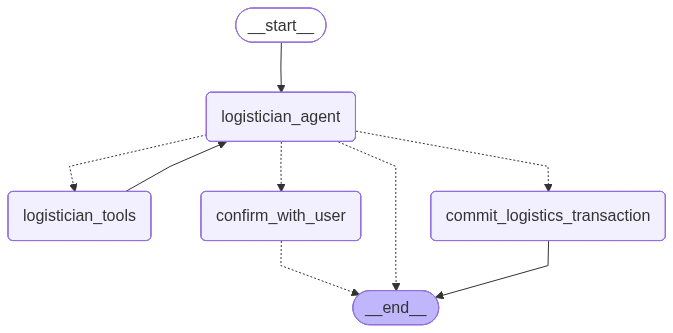

In [9]:
from IPython.display import Image, display
from src.logistician_agent import logistician_agent

# Show the agent
display(Image(logistician_agent.get_graph(xray=True).draw_mermaid_png()))